# Problem Statement:
Plant diseases significantly impact agricultural productivity, leading to economic losses and food security concerns. Traditional methods of disease detection require expert knowledge and are time-consuming. This project aims to develop a Convolutional Neural Network (CNN)-based model to classify potato leaf diseases using image datasets. By leveraging deep learning, the model provides an automated and efficient solution for early disease detection, aiding farmers in taking timely action.

In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from IPython.display import HTML

C:\Users\91886\anaconda3\lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS=3
EPOCHS=40

In [3]:
data= tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [4]:
class_names=data.class_names

In [5]:
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [6]:
len(data)

68

We have 2152 images in dataset but we splited that dataset with each batchsize=32, thats why it showing len as 68.

In [7]:
68*32

2176

In [8]:
for img_batch,label_batch in data.take(1):
    print(img_batch.shape)
    print(label_batch.numpy())

(32, 256, 256, 3)
[1 1 1 0 0 0 0 0 1 1 1 1 0 1 0 1 1 1 0 1 0 1 0 0 1 0 0 1 1 2 0 0]


We have 3 class labels that are stored in class labels, thats why we got 0,1,2 

(32, 256, 256, 3) here 32 in batch size,256 is img dimension, 3 is RGB color

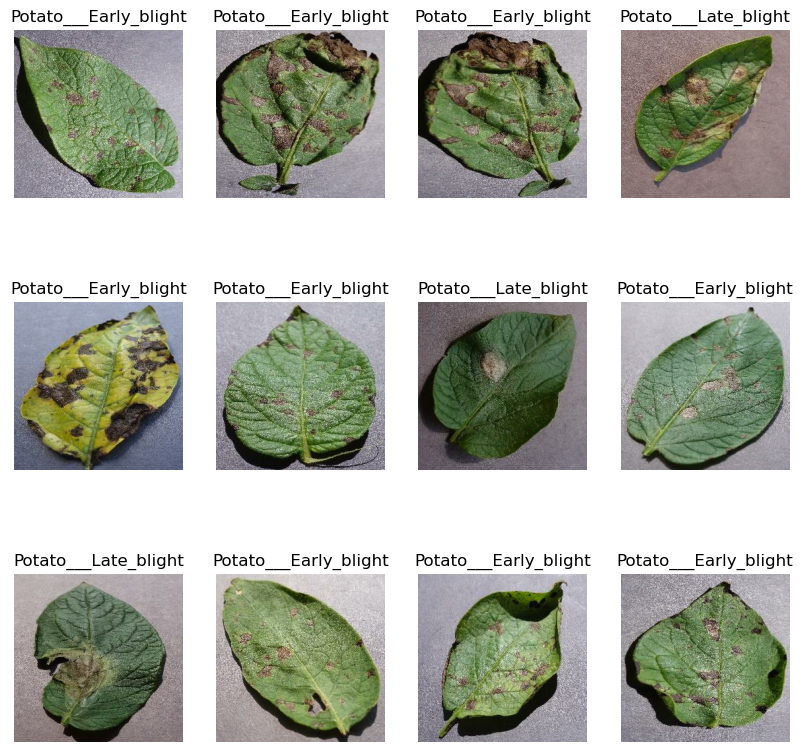

In [9]:
plt.figure(figsize=(10,10))
for img_batch,label_batch in data.take(1):
    for i in range(12):
        ax=plt.subplot(3,4,i+1)
        plt.imshow(img_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]]) 
        plt.axis("off")

# Function to Split Dataset
Dataset should be bifurcated into 3 subsets, namely:

Training: Dataset to be used while training

Validation: Dataset to be tested against while training

Test: Dataset to be tested against after we trained a model

In [10]:
#train dataset 0.8% , we should take 54 batches for training out of 68 batches
len(data)*0.8

54.400000000000006

In [11]:
train=data.take(54)

In [12]:
test=data.skip(54)

In [13]:
len(train),len(test)

(54, 14)

In [14]:
#split test data for validation 0.1
len(data)*0.1

6.800000000000001

In [15]:
val=test.take(6)
test=test.skip(6)

In [16]:
len(train),len(val),len(test)

(54, 6, 8)

# Cache, Shuffle, and Prefetch the Dataset

In [17]:
train_ds = train.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [18]:
resize_and_rescale = tf.keras.Sequential([
    layers.Rescaling(1.0 / 255),
    layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
])

# Data Augmentation

In [19]:
data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2),
])

Applying Data Augmentation to Train Dataset

In [20]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

# Model fitting

In [21]:
input_shape = (IMAGE_SIZE, IMAGE_SIZE, CHANNELS)  # Exclude BATCH_SIZE for input shape
n_classes = 3

model = models.Sequential([
    layers.Input(shape=input_shape),  # Explicitly define the input shape
    resize_and_rescale,               # Preprocessing layer
    layers.Conv2D(32, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

# Print the model summary to verify
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential (Sequential)              │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 254, 254, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 127, 127, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 125, 125, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 62, 62, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 60, 60, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 28, 28, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 12, 12, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 6, 6, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 4, 4, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 2, 2, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │          16,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 3)                   │             195 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 183,747 (717.76 KB)

 Trainable params: 183,747 (717.76 KB)

 Non-trainable params: 0 (0.00 B)

# Compiling the Model

In [22]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [23]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=40,
)

Epoch 1/40
54/54 ━━━━━━━━━━━━━━━━━━━━ 78s 1s/step - accuracy: 0.4551 - loss: 0.9467 - val_accuracy: 0.5625 - val_loss: 0.8741
Epoch 2/40
54/54 ━━━━━━━━━━━━━━━━━━━━ 67s 1s/step - accuracy: 0.6113 - loss: 0.8159 - val_accuracy: 0.7031 - val_loss: 0.5620
Epoch 3/40
54/54 ━━━━━━━━━━━━━━━━━━━━ 64s 1s/step - accuracy: 0.7305 - loss: 0.5720 - val_accuracy: 0.8750 - val_loss: 0.3304
Epoch 4/40
54/54 ━━━━━━━━━━━━━━━━━━━━ 65s 1s/step - accuracy: 0.8296 - loss: 0.3933 - val_accuracy: 0.8646 - val_loss: 0.3198
Epoch 5/40
54/54 ━━━━━━━━━━━━━━━━━━━━ 65s 1s/step - accuracy: 0.8750 - loss: 0.3274 - val_accuracy: 0.9271 - val_loss: 0.1858
Epoch 6/40
54/54 ━━━━━━━━━━━━━━━━━━━━ 64s 1s/step - accuracy: 0.8987 - loss: 0.2474 - val_accuracy: 0.9167 - val_loss: 0.2236
Epoch 7/40
54/54 ━━━━━━━━━━━━━━━━━━━━ 64s 1s/step - accuracy: 0.9302 - loss: 0.2012 - val_accuracy: 0.9688 - val_loss: 0.1274
Epoch 8/40
54/54 ━━━━━━━━━━━━━━━━━━━━ 64s 1s/step - accuracy: 0.9278 - loss: 0.1980 - val_accuracy: 0.9323 - val_loss:

In [24]:
scores = model.evaluate(test_ds)

8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 266ms/step - accuracy: 0.9056 - loss: 0.3350


In [25]:
history

In [26]:
history.params

{'verbose': 1, 'epochs': 40, 'steps': 54}

In [27]:
history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

In [28]:
type(history.history['loss'])

list

In [29]:
len(history.history['loss'])

40

In [30]:
history.history['loss'][:5] # show loss for first 5 epochs

[0.9130022525787354,
 0.7647285461425781,
 0.5390147566795349,
 0.36681026220321655,
 0.3258376717567444]

In [31]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

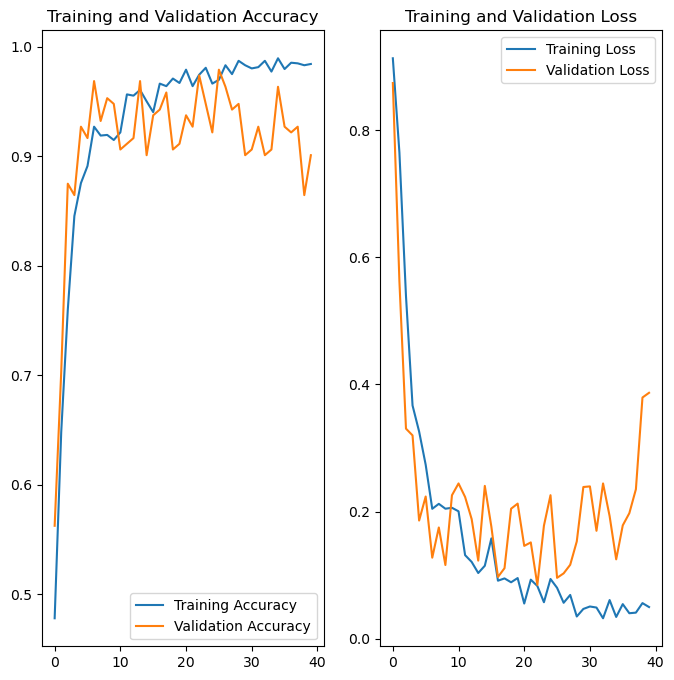

In [32]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Run prediction on a sample image

first image to predict
actual label: Potato___Late_blight
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 555ms/step
predicted label: Potato___Late_blight


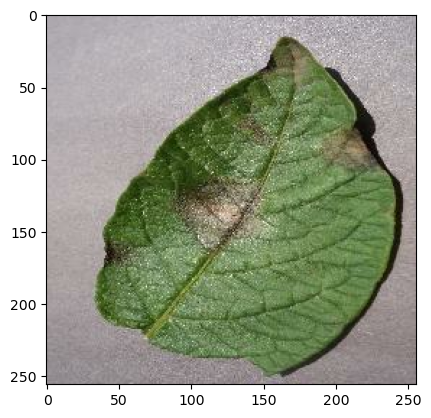

In [33]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

# function for inference

In [34]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

Now run inference on few sample images

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


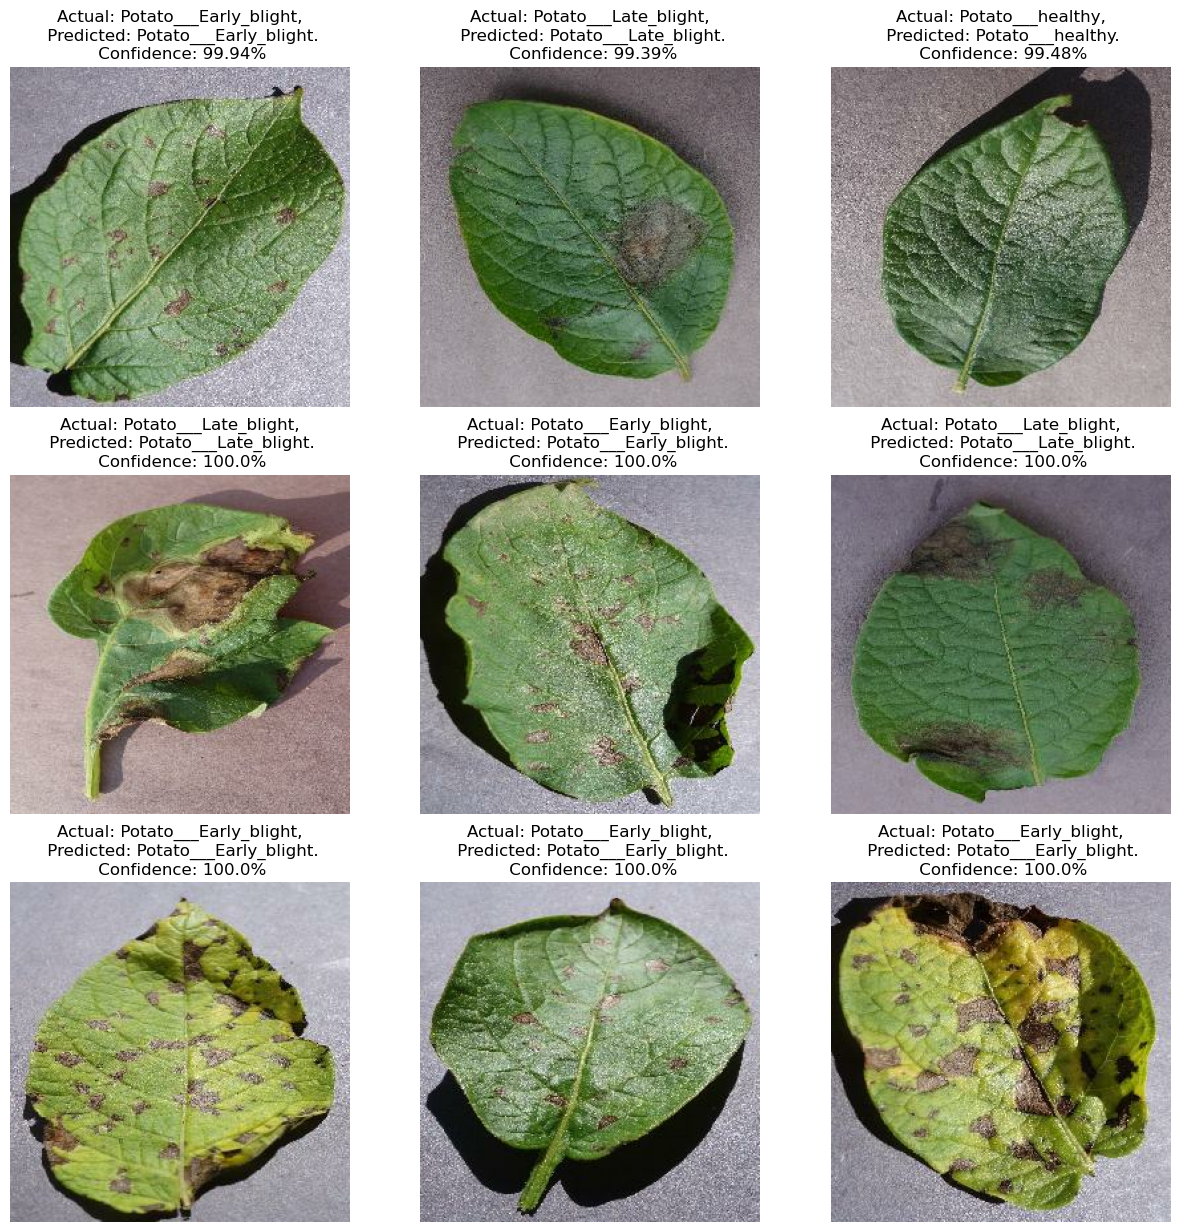

In [35]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

# Conclusion:

Data Preprocessing & Preparation:
The dataset consisted of images categorized into three classes: Potato Early Blight, Potato Late Blight, and Healthy.
Images were resized, normalized, and split into training and validation sets for better model generalization.

Model Development & Training:
A CNN architecture was designed and trained using TensorFlow and Keras to classify plant diseases based on leaf images.
The model was trained with 40 epochs and a batch size of 32, ensuring sufficient learning over multiple iterations.
Data augmentation techniques were applied to enhance model robustness and avoid overfitting.

Performance Evaluation:
The model achieved high classification accuracy in identifying plant diseases from leaf images.
The use of multiple convolutional layers helped capture intricate patterns in leaf textures.
Validation accuracy and loss trends indicated effective learning and generalization of the model.

Challenges & Limitations:
The dataset size was limited, which could impact real-world performance.
Model accuracy could be affected by variations in lighting, background noise, and image quality.
The CNN model requires computational resources for training, which may limit deployment on low-end devices.

Future Enhancements:
Expanding the dataset with diverse plant species and environmental conditions to improve generalization.
Implementing real-time disease detection using mobile applications integrated with the trained model.
Exploring advanced architectures like transfer learning (e.g., VGG16, ResNet) for further accuracy improvements.

Final Thoughts:
The project successfully demonstrated the potential of CNNs in plant disease classification.
By automating disease detection, this model can help farmers take timely preventive measures, reducing crop losses.
With further improvements, this approach could be scaled for large-scale agricultural applications, contributing to precision farming and sustainable agriculture.